In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
from collections import Counter
from torch.utils.data import Dataset, DataLoader

In [2]:
X, y = make_multilabel_classification(n_samples=1000, n_features=20, n_classes=3, n_labels=2, random_state=1)
X_torch = torch.FloatTensor(X)
y_torch = torch.FloatTensor(y)

X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size=0.2)

In [3]:
class MultiLabelData(Dataset):
    def __init__(self,X,y):
        self.x = X
        self.y = y
        self.len = len(self.x)
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]


In [4]:
multilabeldata = MultiLabelData(X_train, y_train)
data_loader = DataLoader(multilabeldata, batch_size=10, shuffle=True)


In [5]:
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_features,num_classes,neurons):
        super().__init__()
        self.lin1 = nn.Linear(num_features,neurons)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(neurons, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,X):
        X = self.lin1(X)
        X = self.relu(X)
        X = self.lin2(X)
        X = self.sigmoid(X)
        return X
    
model = MultiLabelClassifier(num_features=X_train.shape[1],num_classes=y_train.shape[1],neurons=20)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000

losses=[]
for epoch in range(epochs):
    for x,y in data_loader:
        optimizer.zero_grad()

        yhat = model(x)
        loss = loss_func(yhat, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if epoch%100 == 0:
        print(f"epoch: {epoch}, loss: {loss.data.item()}")

epoch: 0, loss: 0.5817158818244934
epoch: 100, loss: 0.5033553838729858
epoch: 200, loss: 0.4652159810066223
epoch: 300, loss: 0.46521618962287903
epoch: 400, loss: 0.5411950349807739
epoch: 500, loss: 0.5037999749183655
epoch: 600, loss: 0.45255306363105774
epoch: 700, loss: 0.5112120509147644
epoch: 800, loss: 0.5032044649124146
epoch: 900, loss: 0.49054262042045593


Naive Classifier Accuracy: 30.0%
Test accuracy: 67.0%


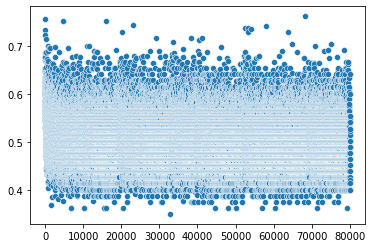

In [6]:
sns.scatterplot(x = range(len(losses)), y = losses)

with torch.no_grad():
    X_test_torch = torch.FloatTensor(X_test)
    y_test_hat = model(X_test_torch).round()

y_test_str = [str(i) for i in y_test.detach().numpy()]
most_common_cnt = Counter(y_test_str).most_common()[0][1]
print(f"Naive Classifier Accuracy: {most_common_cnt/len(y_test_str) * 100}%")

test_acc = accuracy_score(y_test, y_test_hat)
print(f"Test accuracy: {test_acc * 100}%")